In [1]:
# Launch 7 parallel processes and load module in all
using Distributed
addprocs(7)

using Statistics
@everywhere using QuantumOptics
@everywhere using QuantumBayesian
using PyPlot
using Pkg

# One Qubit Stochastic Monitoring Test

**Justin Dressel**, Jan 4, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the Quantum Bayesian update code for Julia produce sensible results for the simplest quantum problem of monitoring the observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z and/or y observables.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = SpinBasis(1//2)
@everywhere _z = spinup(q)
@everywhere _zm = spindown(q)
@everywhere _y = (_z + im*_zm)/sqrt(2)
@everywhere _x = (_z + _zm)/sqrt(2)
@everywhere Z = dm(_z)
@everywhere Y = dm(_y)
@everywhere X = dm(_x)
@everywhere Zm = dm(_zm)
@everywhere x(ρ) = 2real(expect(ρ, X) .- 0.5);
@everywhere y(ρ) = 2real(expect(ρ, Y) .- 0.5);
@everywhere z(ρ) = 2real(expect(ρ, Z) .- 0.5);

In [3]:
# Parameters
@everywhere Ω  = 2π;        # Rabi frequency, unit period
@everywhere τ = 3.0;         # Measurement collapse timescale (given quantum-limited efficiency)
@everywhere Γ = 1/(2τ);     # Measurement dephasing rate
@everywhere T = (0.0, 3τ);  # Time duration of simulation;

# Hamiltonian: oscillations in x-z plane
@everywhere H = (Ω/2)*Y;

# Initial ground state
@everywhere ρ0 = Zm;

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sol; plot_title="Monitored Rabi Oscillation", readout=false, ymeas=false, stds=[])
    # Plot Bloch components vs. time
    figure(1)
    ax = gca()
    plot(sol[1].t, sol[1], label=L"$x$", color="r")
    plot(sol[2].t, sol[2], label=L"$y$", color="g")
    plot(sol[3].t, sol[3], label=L"$z$", color="b")
    if length(stds) > 0
        fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
        fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
        fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="b", alpha=0.2, antialiased=true)
    end
    xlabel(L"$t\,\nu$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
    if readout
        figure(2)
        plot(sol[4].t, sol[4], label=L"$r_z$", color="b")
        ymeas && plot(sol[5].t, sol[5], label=L"$r_y$", color="g")
        if length(stds) > 0
            fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="b", alpha=0.2, antialiased=true)
            ymeas && fill_between(sol[5].t, sol[5]-stds[5], sol[5]+stds[5], color="g", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t\,\nu$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = -i[H,\,\rho] + \frac{\Gamma}{2}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_y$ if both axes have dephasing.

In [5]:
# Measurement dephasing
@everywhere DMz = sqrt(Γ/2)*Z;
@everywhere DMy = sqrt(Γ/2)*Y;
@everywhere DM(t) = cos(2Ω*t)*DMz + sin(2Ω*t)*DMy;

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(; Δt=1/10^2, ymeas=false, tmeas=false, verbose=true)
    # Jump/no-jump Lindblad simulation
    inc = lind(Δt, H, clist=[DMz])
    ymeas && (inc = lind(Δt, H, clist=[DMz, DMy]))
    tmeas && (inc = lind(Δt, H, flist=[DM]))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose)
end;

  0.048722 seconds (90.63 k allocations: 6.505 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Time elapsed: 
│   elapsed = 0.04290199279785156
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 20978.0465033566
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


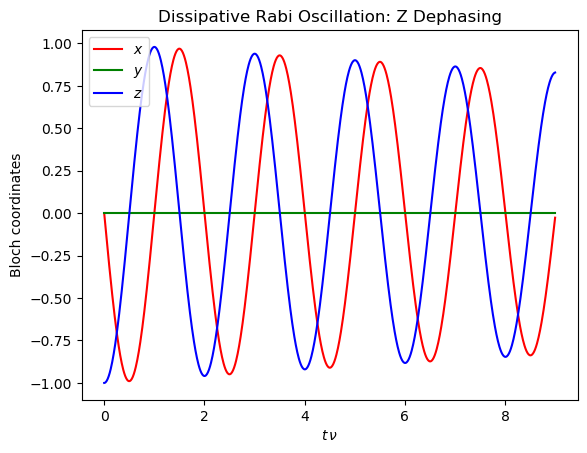

In [43]:
sol = ensemble_average(verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average()
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z Dephasing")

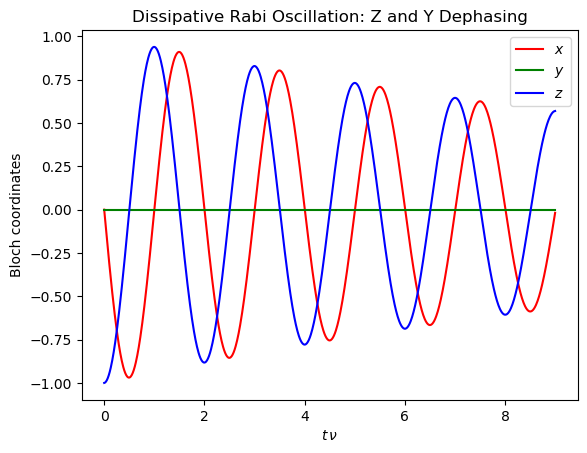

  0.011936 seconds (105.73 k allocations: 7.423 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Time elapsed: 
│   elapsed = 0.011425018310546875
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 78774.49081803006
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [7]:
sol = ensemble_average(ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average(ymeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z and Y Dephasing")

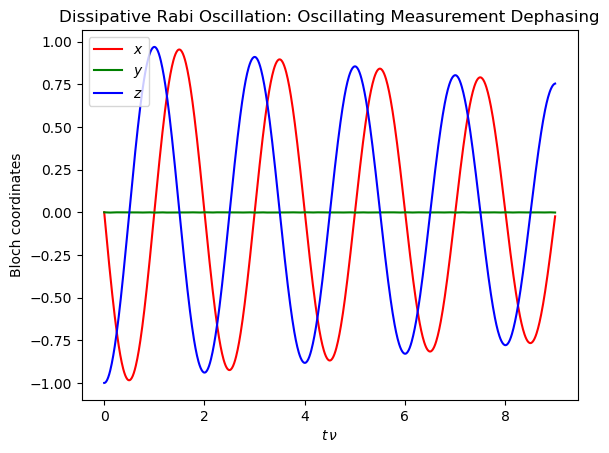

  0.025895 seconds (237.13 k allocations: 15.525 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Time elapsed: 
│   elapsed = 0.025342226028442383
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 35513.84945386808
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [8]:
sol = ensemble_average(tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average(tmeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Oscillating Measurement Dephasing")

## Stochastic Dynamics Tests

Now we examine single trajectories and ensembles of trajectories carefully, to make sure they agree with the ensemble-averaged Lindblad dynamics.

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = -i[H,\,\rho]dt + \frac{\Gamma}{2}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{2}}\left[\sigma_z\,e^{-i\phi}\,\rho + \rho\,\sigma_z^\dagger\,e^{i\phi} - \langle\sigma_z\,e^{-i\phi} + \sigma_z^\dagger\,e^{i\phi}\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z\,e^{-i\phi} \equiv A_r - i\, A_i $$
whose real (Hermitian) part corresponds to the measured observable, and whose imaginary (anti-Hermitian) part corresponds to the phase back-action. 

This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -i\,\frac{dt\,A_i}{2\tau}\, -\, \frac{dt\,(r-A_r)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A_r^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A_r \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the Lindblad equation:
$$ \rho(t+dt) = \frac{\gamma\,dt}{2}\,\sigma_z\,\rho(t)\,\sigma_z^\dagger + \sqrt{1 - \frac{\gamma\,dt}{2}\sigma_z^\dagger\sigma_z}\,\rho(t)\,\sqrt{1 - \frac{\gamma\,dt}{2}\sigma_z^\dagger\sigma_z} $$

This complete unraveling into exact discrete-step Kraus operators has the enormous benefit of being a valid completely positive map that preserves the properties of the state. Other methods for integrating the stochastic master equation do not converge in precision easily, comparatively.

In [6]:
function ensemble_realization(; Δt=1/10^2, η=1.0, n=1, ymeas=false, tmeas=false, ϕ=0.0, verbose=true)
    # Monitoring with tunable quantum efficiency
    if ymeas
        inc = meas(Δt, H, mclist=[(exp(-im*ϕ) * Z, τ/η, η), (exp(-im*ϕ) * Y, τ/η, η)])
    elseif tmeas
        inc = meas(Δt, H, mflist=[(t -> cos(2Ω*t)*exp(-im*ϕ) * Z + sin(2Ω*t)*exp(-im*ϕ) * Y, τ/η, η)])
    else
        inc = meas(Δt, H, mclist=[(exp(-im*ϕ) * Z, τ/η, η)])
    end

    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    end
end;

### Single Trajectory Examples

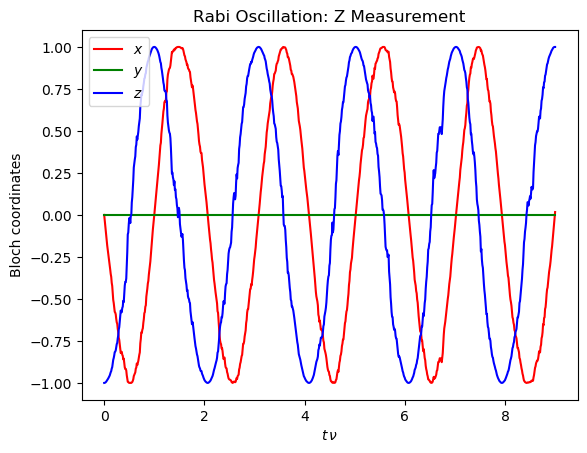

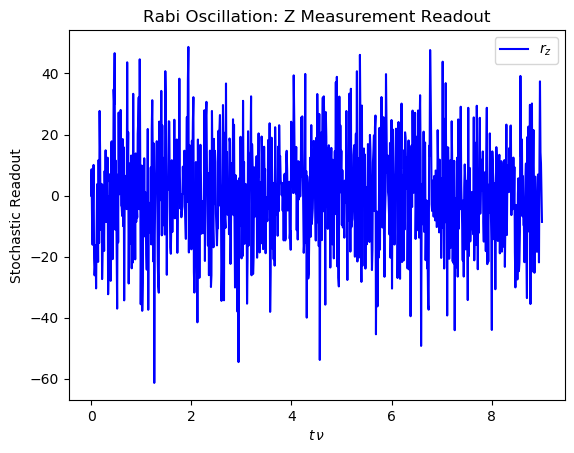

  0.089727 seconds (163.01 k allocations: 9.616 MiB, 24.37% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.0156400203704834
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 57544.68208356835
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [10]:
sol = ensemble_realization(verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization()
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Measurement")

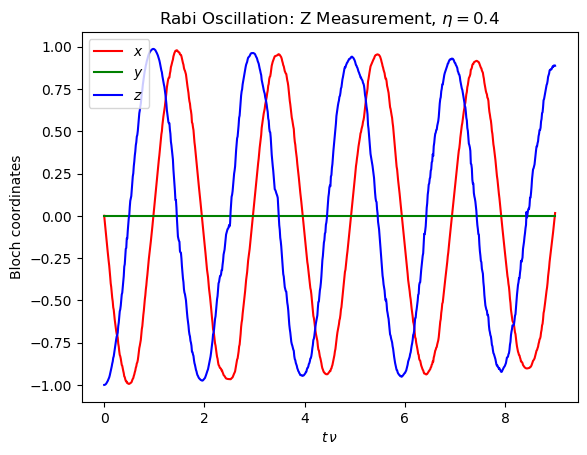

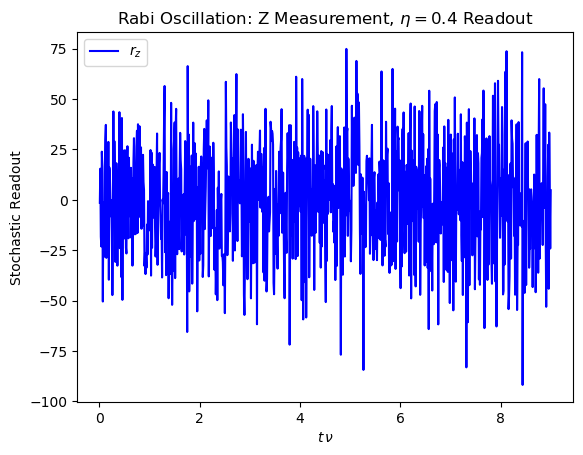

  0.032568 seconds (155.18 k allocations: 11.460 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.03192901611328125
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 28187.52688172043
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [11]:
sol = ensemble_realization(η=0.4,verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Measurement, $\eta=0.4$")

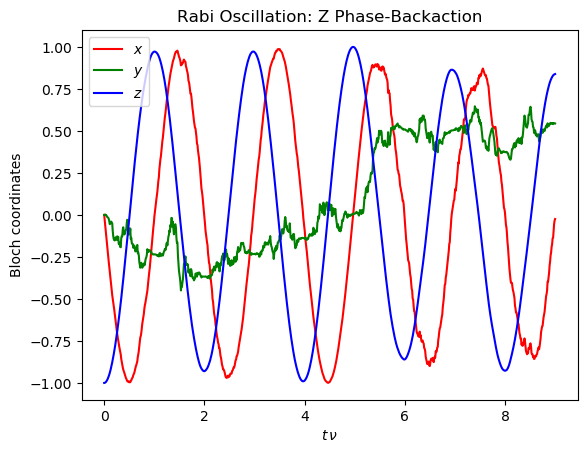

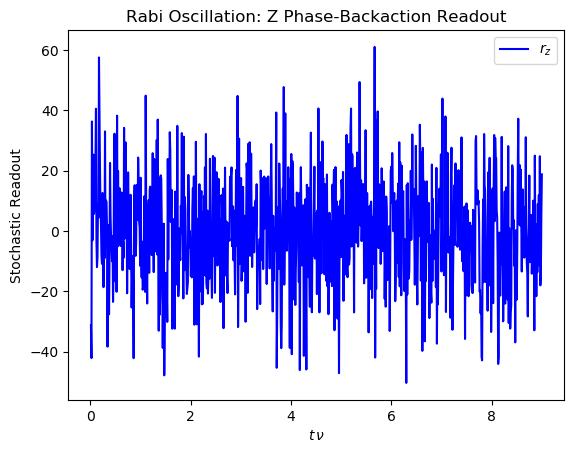

  0.017152 seconds (94.92 k allocations: 5.578 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.01664280891418457
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 54077.409927655615
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [12]:
sol = ensemble_realization(ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction")

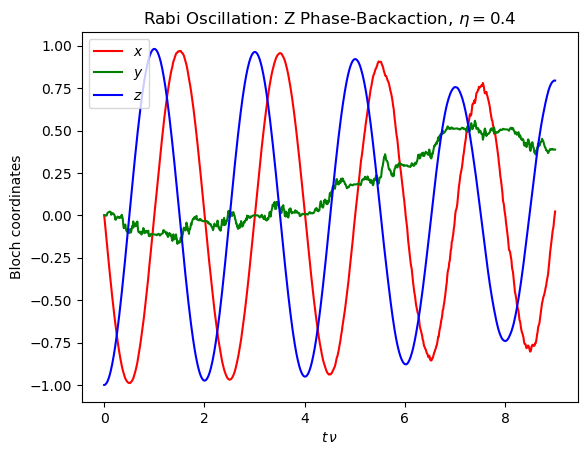

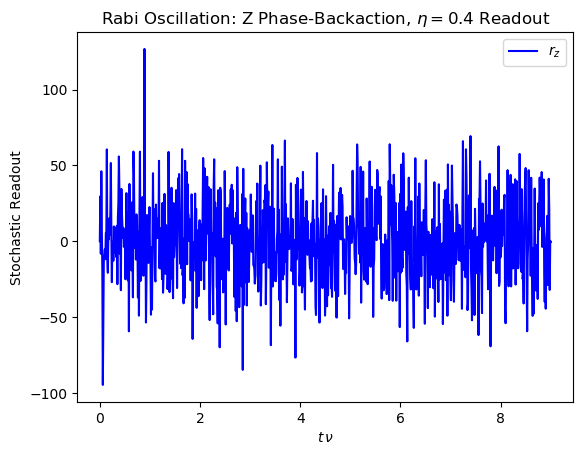

  0.058031 seconds (153.08 k allocations: 10.834 MiB, 31.65% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.05736804008483887
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 15688.177575336944
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [13]:
sol = ensemble_realization(ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Phase-Backaction, $\eta=0.4$")

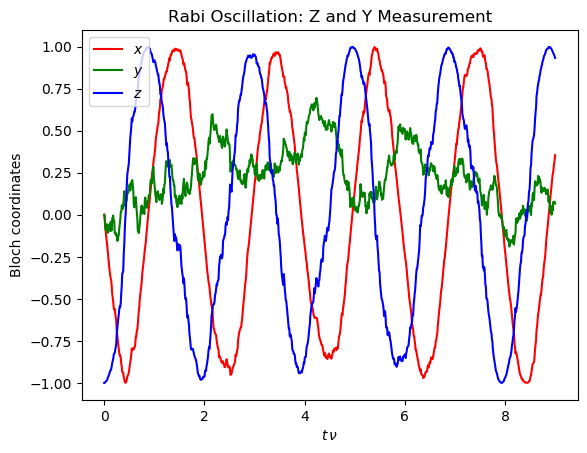

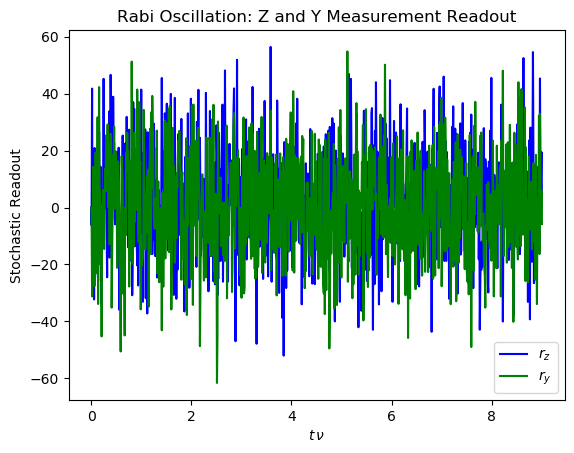

  0.024765 seconds (141.33 k allocations: 10.432 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.02420806884765625
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 37177.68673179956
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [14]:
sol = ensemble_realization(ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement")

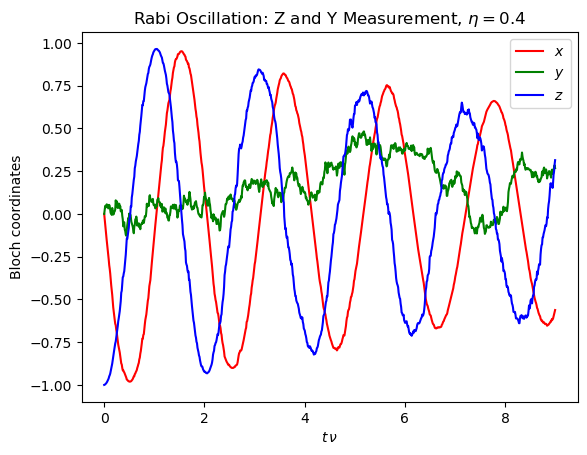

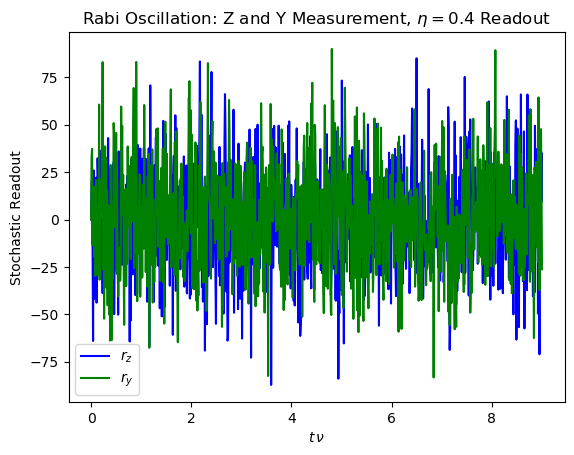

  0.034606 seconds (215.14 k allocations: 16.709 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.03386211395263672
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 26578.376094854535
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [15]:
sol = ensemble_realization(ymeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Measurement, $\eta=0.4$")

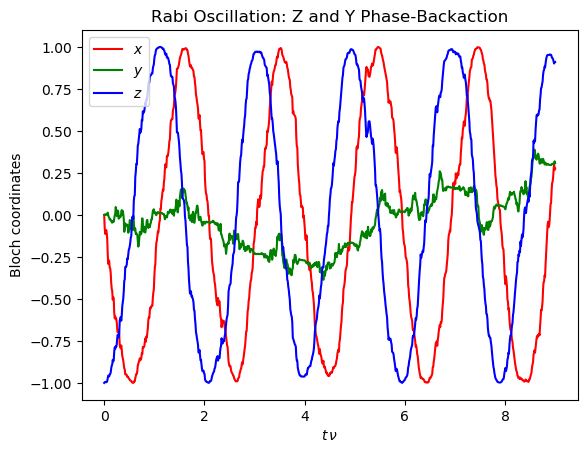

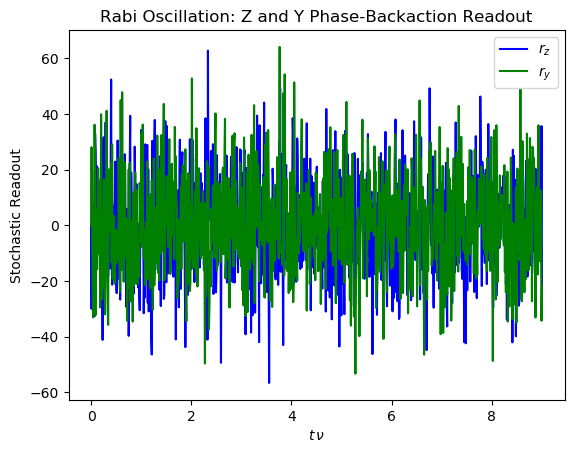

  0.022452 seconds (137.85 k allocations: 9.384 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.021883010864257812
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 41127.795694238645
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [16]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction")

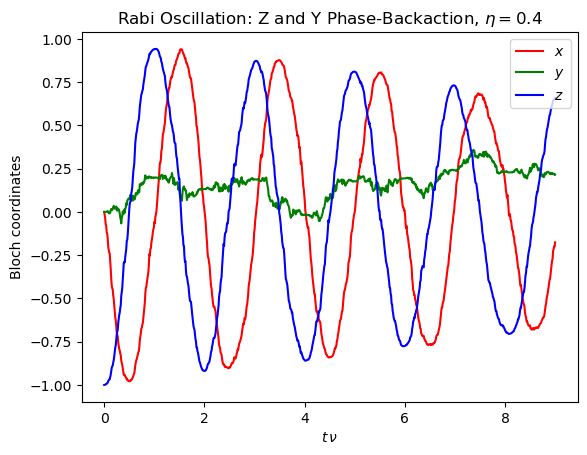

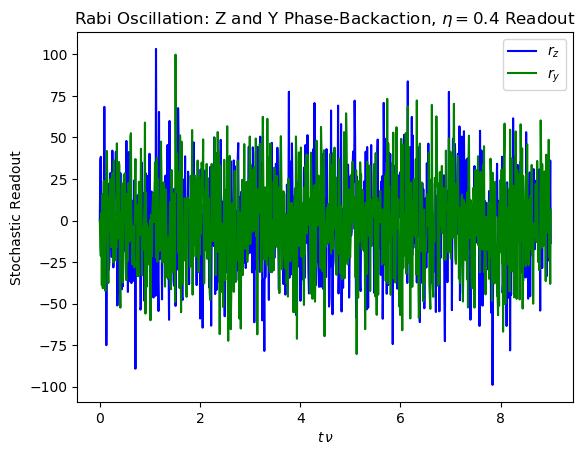

  0.042978 seconds (210.01 k allocations: 15.424 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.04230618476867676
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 21273.48530530587
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [17]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Phase-Backaction, $\eta=0.4$")

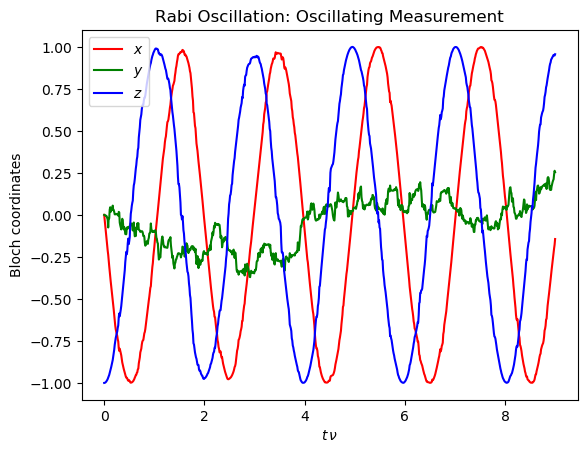

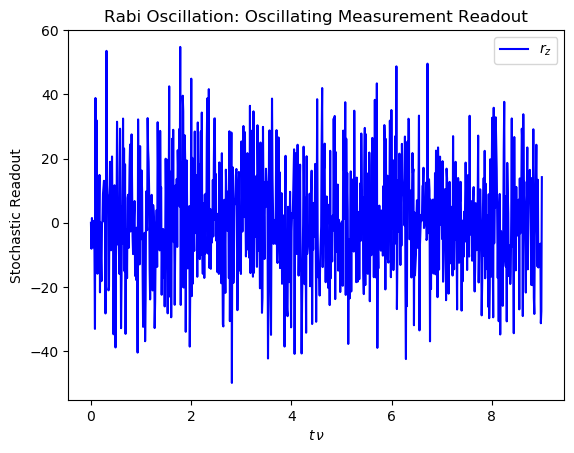

  0.024192 seconds (221.84 k allocations: 11.520 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.02361607551574707
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 38109.634236216974
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [18]:
sol = ensemble_realization(tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Measurement")

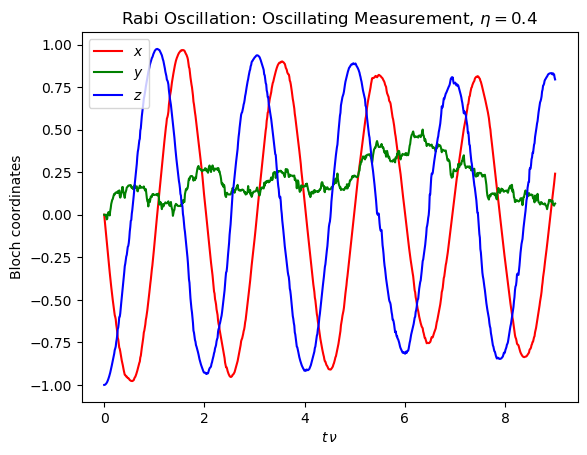

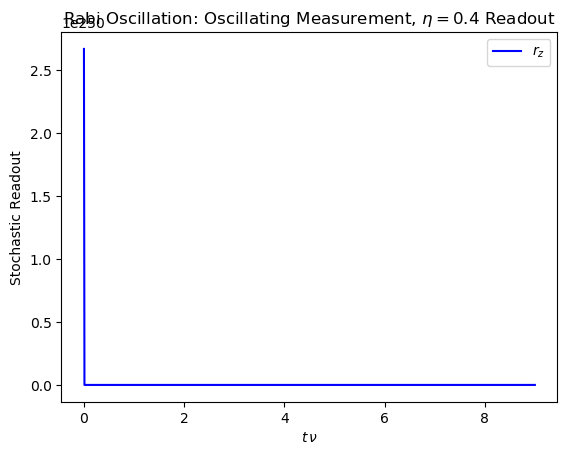

  0.059473 seconds (475.64 k allocations: 28.069 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.0587000846862793
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 15332.17549531693
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [19]:
sol = ensemble_realization(tmeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Measurement, $\eta=0.4$")

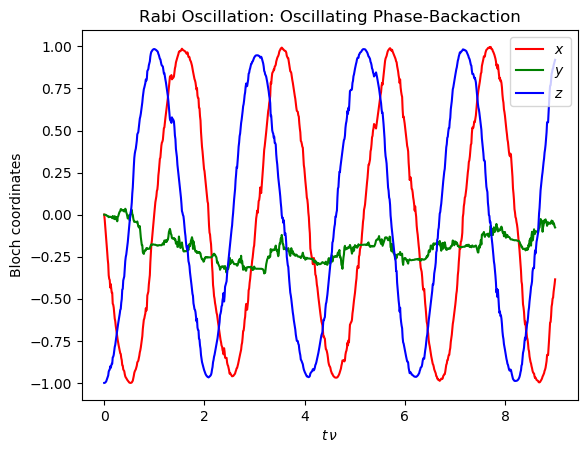

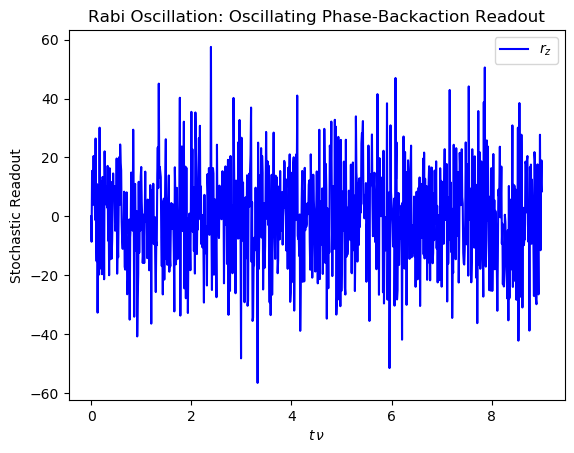

  0.032655 seconds (220.13 k allocations: 11.000 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.032086849212646484
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 28048.87429225305
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [20]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction")

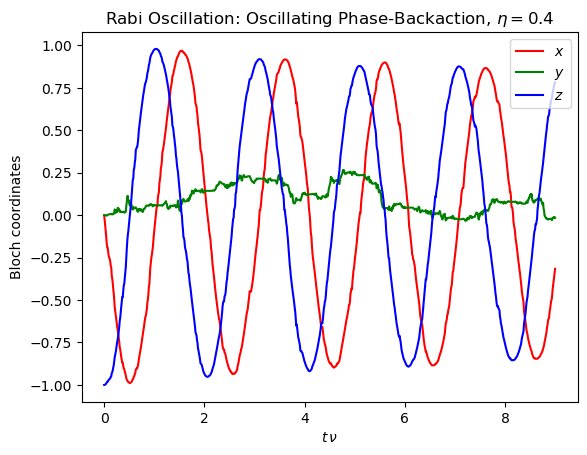

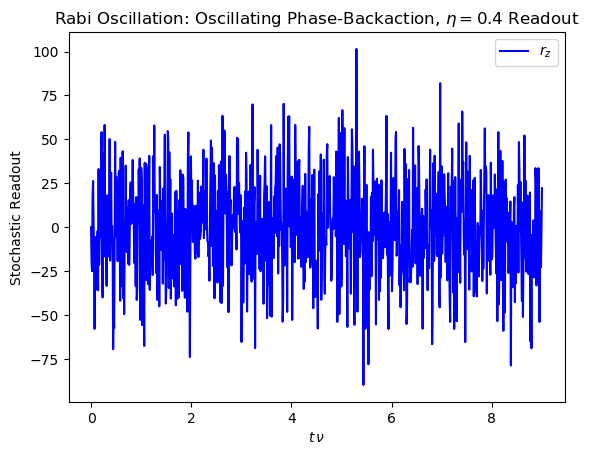

  0.068792 seconds (473.13 k allocations: 27.433 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 900
│   , points =  = , points = 
│   Ns = 900
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:625
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.06807112693786621
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 13221.464672114209
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:643


In [21]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Phase-Backaction, $\eta=0.4$")

### Ensembles of trajectories

In [18]:
# Ensemble size, for easy tunability
num = 2000;

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


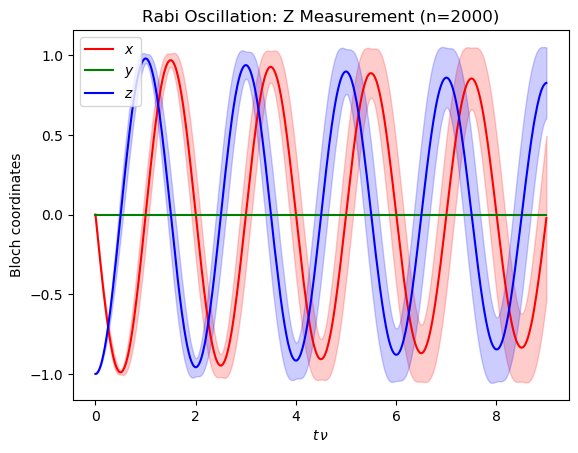

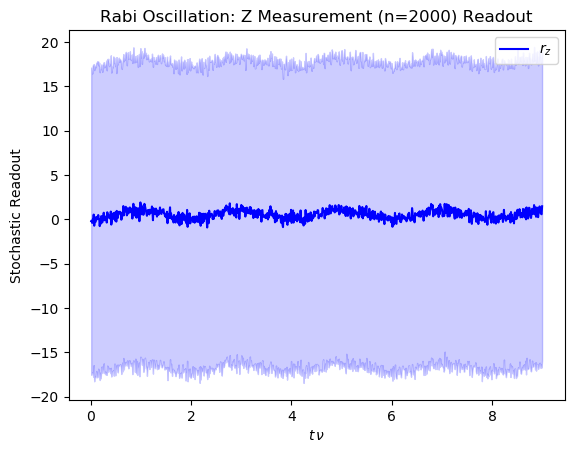

 17.518901 seconds (261.95 k allocations: 119.213 MiB, 0.18% gc time)


┌ Info: Time elapsed: 
│   elapsed = 17.489238023757935
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 102920.43584487918
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [10]:
ensemble_realization(n=2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Measurement (n=$num)")

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


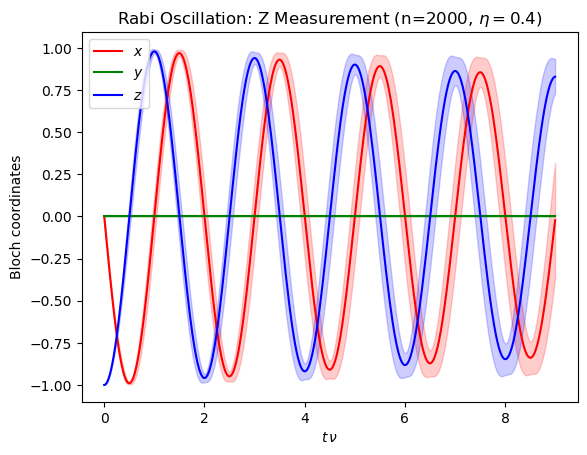

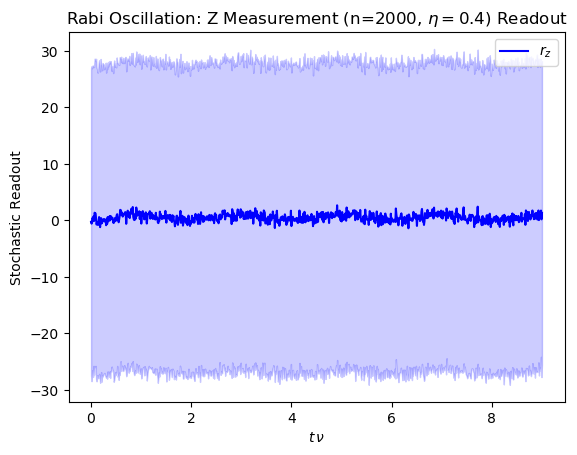

 75.779584 seconds (4.21 M allocations: 313.823 MiB, 1.41% gc time)


┌ Info: Time elapsed: 
│   elapsed = 71.03102898597717
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 25341.03793365225
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [19]:
e = ensemble_realization(n=2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Measurement (n=$num, \$\\eta=0.4\$)"))

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


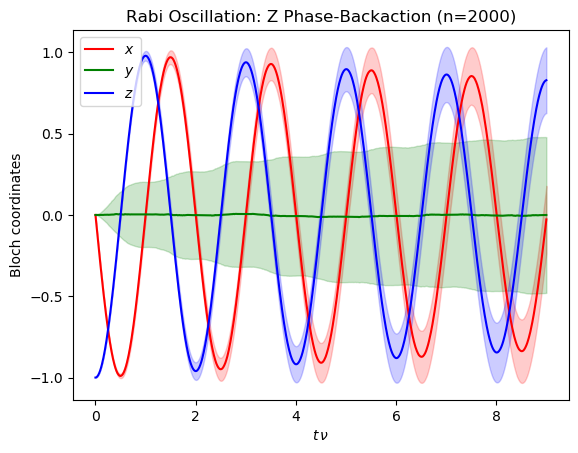

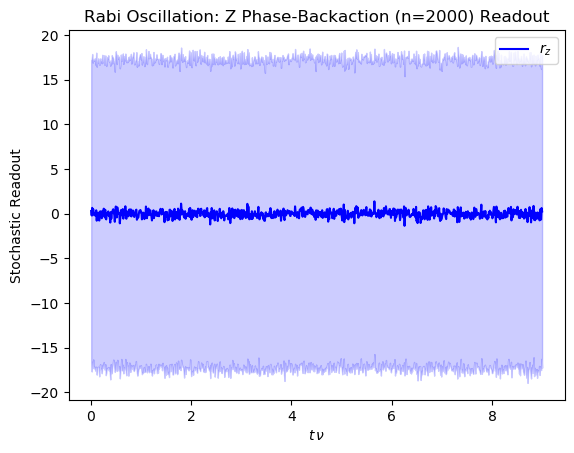

 24.216156 seconds (263.84 k allocations: 119.760 MiB, 0.38% gc time)


┌ Info: Time elapsed: 
│   elapsed = 23.97492289543152
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 75078.44792038912
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [20]:
e = ensemble_realization(n=2, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction (n=$num)")

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


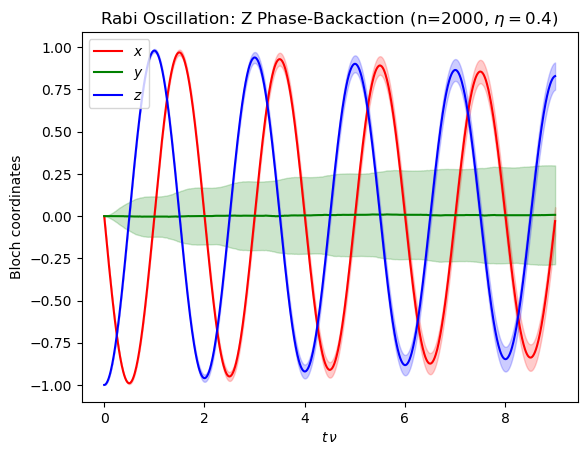

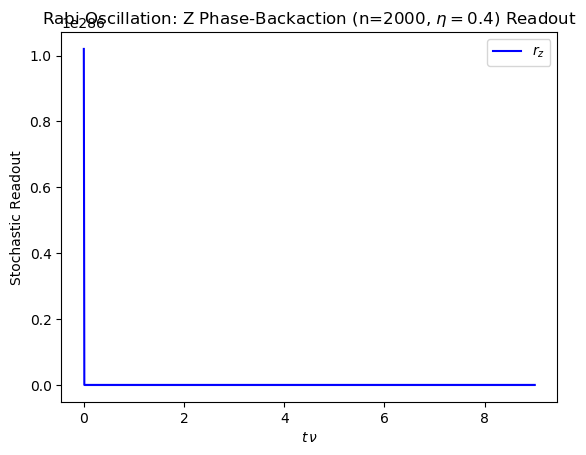

 32.921648 seconds (264.89 k allocations: 119.766 MiB, 0.60% gc time)


┌ Info: Time elapsed: 
│   elapsed = 32.87394404411316
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 54754.61044724665
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [21]:
e = ensemble_realization(n=2, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Phase-Backaction (n=$num, \$\\eta=0.4\$)"))

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


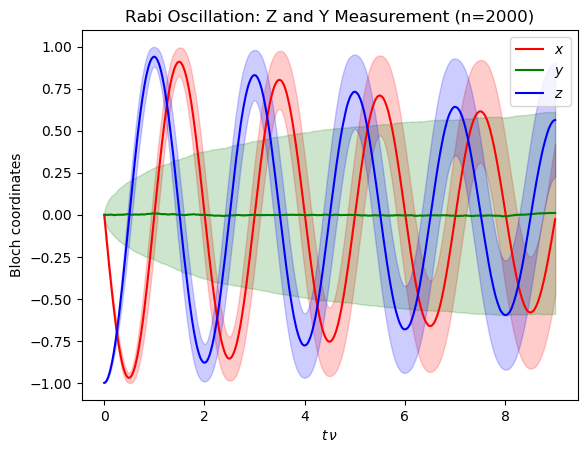

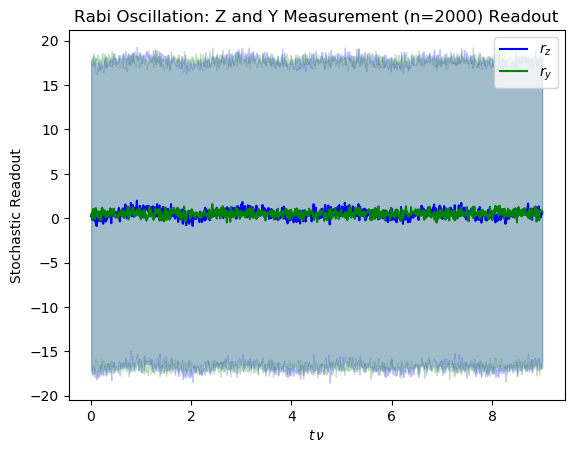

 50.114790 seconds (272.95 k allocations: 147.860 MiB, 0.08% gc time)


┌ Info: Time elapsed: 
│   elapsed = 49.947563886642456
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 36037.793636645736
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [22]:
e = ensemble_realization(n=2, ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement (n=$num)")

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


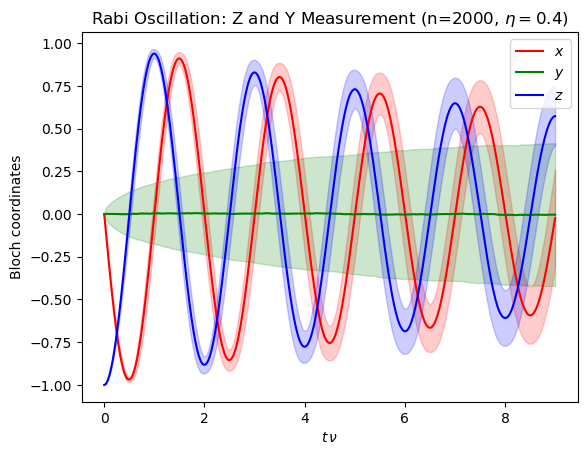

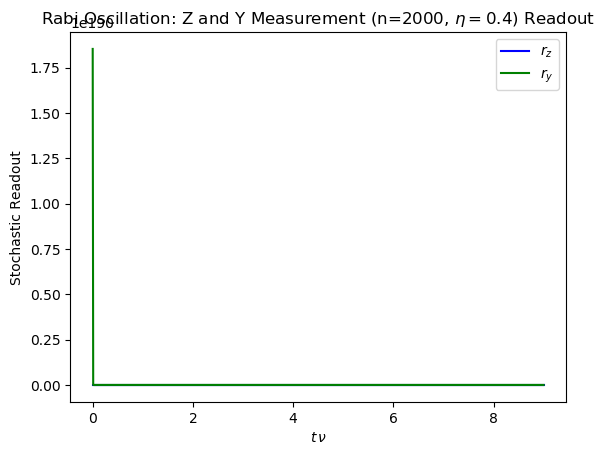

 64.520936 seconds (275.63 k allocations: 148.089 MiB, 2.44% gc time)


┌ Info: Time elapsed: 
│   elapsed = 64.2717080116272
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 28006.101839931925
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [23]:
e = ensemble_realization(n=2, ymeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Measurement (n=$num, \$\\eta = 0.4\$)"))

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


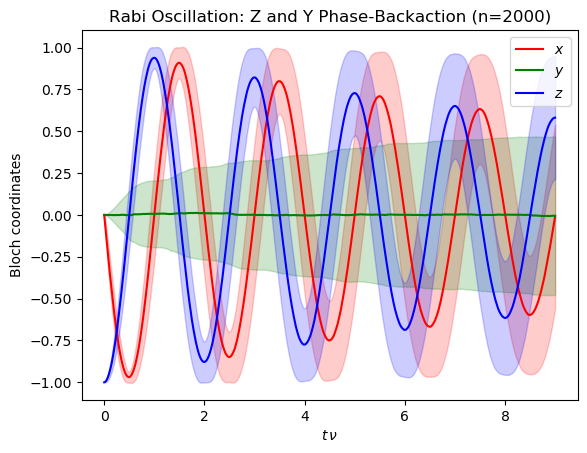

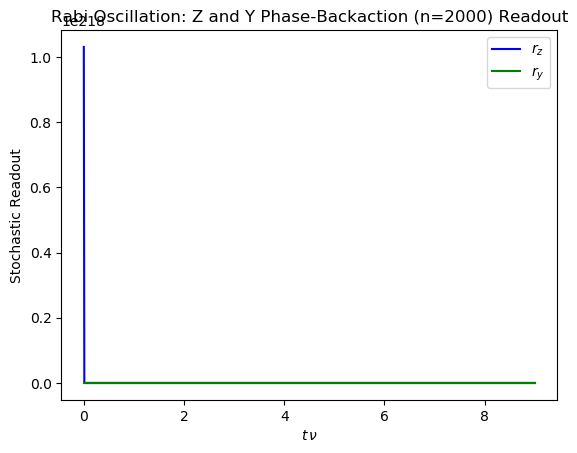

 42.694774 seconds (277.12 k allocations: 147.866 MiB, 0.10% gc time)


┌ Info: Time elapsed: 
│   elapsed = 42.58610010147095
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 42267.31247310967
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [24]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction (n=$num)")

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 2
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


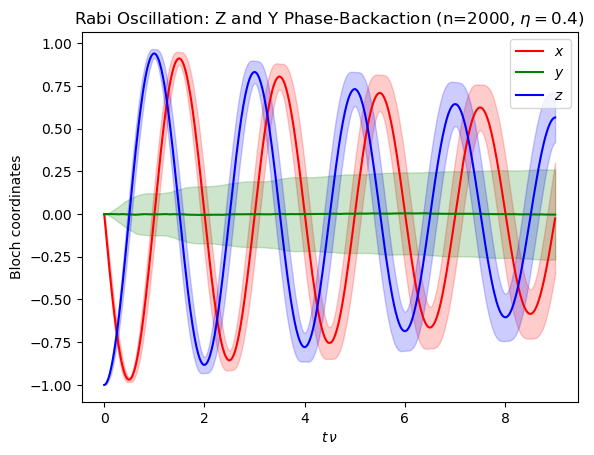

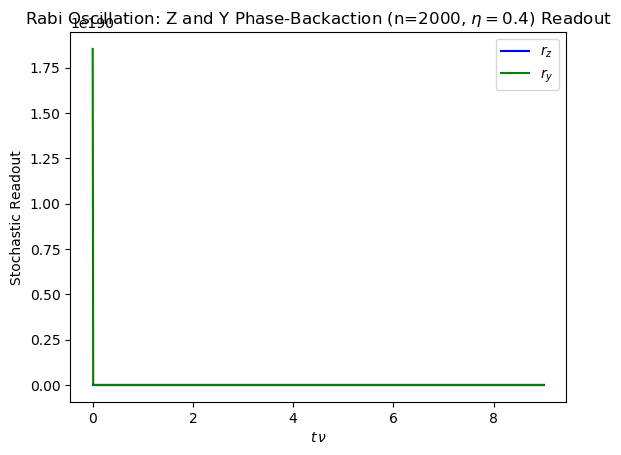

 76.066079 seconds (278.81 k allocations: 147.958 MiB, 0.05% gc time)


┌ Info: Time elapsed: 
│   elapsed = 75.7724859714508
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 23755.324599989966
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [25]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


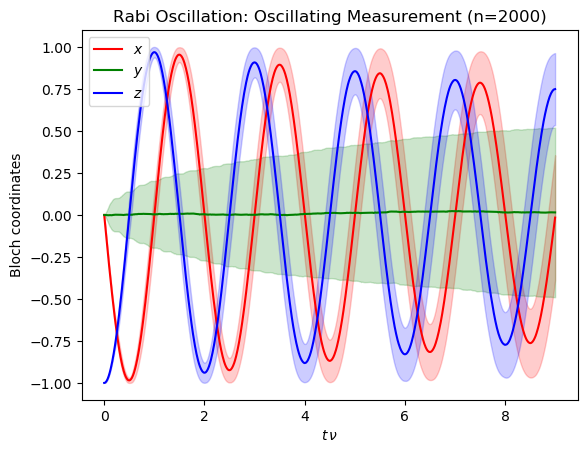

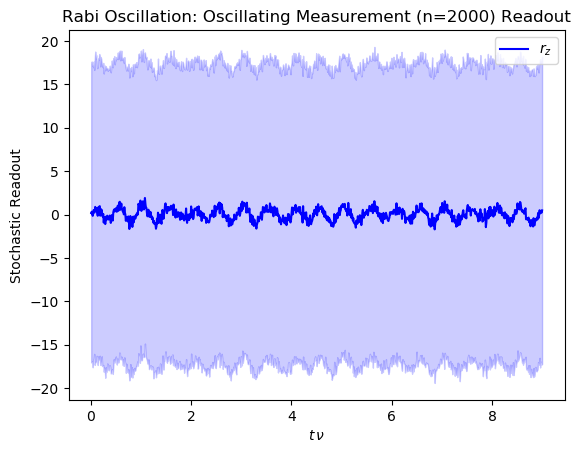

 92.270661 seconds (439.11 k allocations: 127.736 MiB, 0.25% gc time)


┌ Info: Time elapsed: 
│   elapsed = 89.37393689155579
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 20140.09970472798
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [26]:
e = ensemble_realization(n=2, tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Measurement (n=$num)")

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


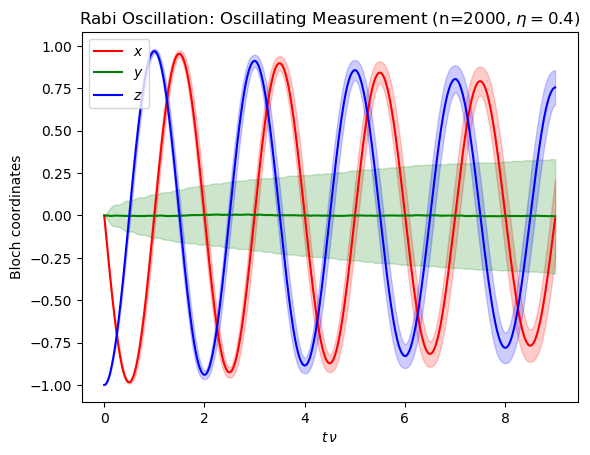

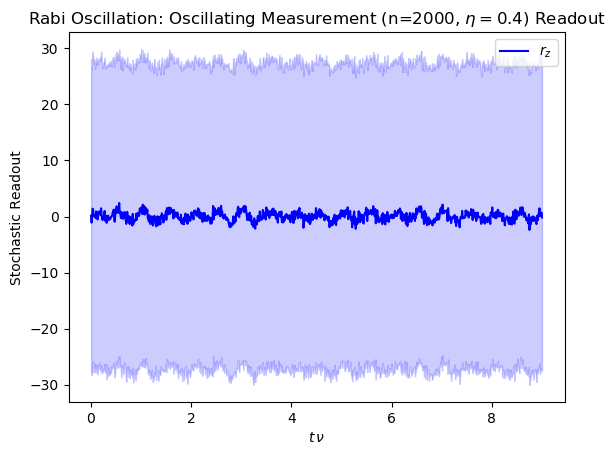

 92.550625 seconds (394.52 k allocations: 126.574 MiB, 0.22% gc time)


┌ Info: Time elapsed: 
│   elapsed = 91.28810906410217
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 19717.792584969055
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [27]:
e = ensemble_realization(n=2, tmeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Measurement (n=$num, \$\\eta = 0.4\$)"))

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


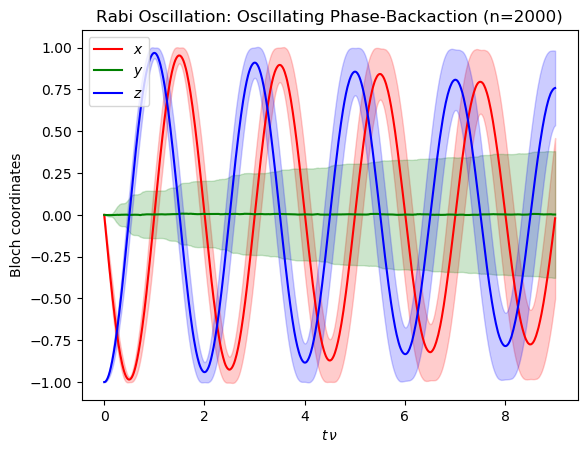

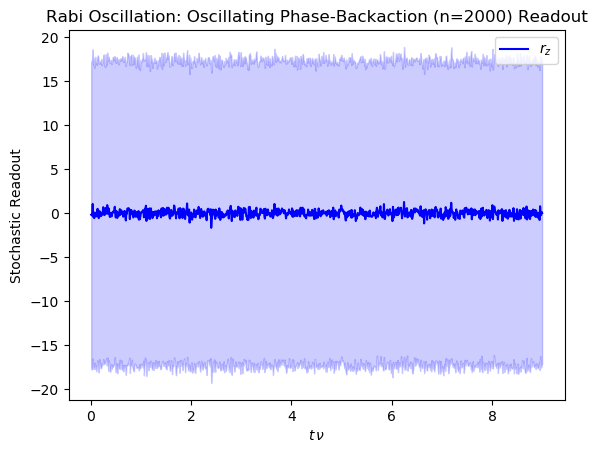

 77.577280 seconds (264.60 k allocations: 119.776 MiB, 2.02% gc time)


┌ Info: Time elapsed: 
│   elapsed = 75.76020693778992
│    s, Steps:  =  s, Steps: 
│   steps = 1800000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 23759.17480634735
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:571


In [28]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction (n=$num)")

In [ ]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

┌ Info: Trajectories: 
│   n = 2000
│   , steps each:  = , steps each: 
│   N = 899
│   , points each:  = , points each: 
│   min(N, points) = 899
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:550
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:553


## Conclusions

The Quantum Bayesian method for computing stochastic evolution works well and is competitive in speed with the direct Lindblad integration. It is both dramatically faster and much more accurate than any of the currently available stochastic integration solvers in the ```DifferentialEquations``` package.

## Version Information

In [35]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7660U CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
